Image transformation routines

In [1]:
%load_ext autoreload
%autoreload 2

# Export cells
!python notebook2script.py transforms.ipynb

Converted transforms.py to torchtrainer/transforms.py


In [33]:
# Transformations and data augmentation
#export transforms.py
'''
Image transformation routines
'''

import imgaug as ia
import numpy as np
import torch
from torchvision import transforms as torch_transforms
import cv2
from PIL import Image
from functools import partial

class TransfNormalize:
    
    def __init__(self, transf_img=True, transf_label=False, transf_weight=False):
        '''For imgaug normalization, an image and either a label or weight need to be passed.'''
        
        self.transf_img = transf_img
        self.transf_label = transf_label
        self.transf_weight = transf_weight
        
    def __call__(self, img=None, label=None, weight=None):
        
        np_conv_func = partial(np.array, dtype=float, copy=False)
        
        img_type = data_type(img, label, weight)
        if img_type=='numpy':
            if self.transf_img:
                img =  np_conv_func(img)/255.
            if self.transf_label:
                label = label//255
            if self.transf_weight:
                weight = weight/255.
        elif img_type=='pil':
            if self.transf_img:
                if self.validate_pil(img):
                    img = numpy_to_pil(np_conv_func(pil_to_numpy(img))/255.)
            if self.transf_label:
                if self.validate_pil(label):
                    label = numpy_to_pil(pil_to_numpy(label)//255)
            if self.transf_weight:
                if self.validate_pil(weight):
                    weight = numpy_to_pil(pil_to_numpy(weight)/255.)      
        elif img_type=='imgaug':
            if self.transf_img:
                img =  np_conv_func(img)/255.
            if self.transf_label:
                label = ia.SegmentationMapsOnImage(label.get_arr()//255)
            if self.transf_weight:
                weight = ia.HeatmapsOnImage(weight.get_arr()/255.)
        elif img_type=='tensor':
            if self.transf_img:
                img =  img.float().div(255.)
            if self.transf_label:
                label = label.div(255)
            if self.transf_weight:
                weight = weight.div(255.)

        ret = []
        if img is not None: ret.append(img)
        if label is not None: ret.append(label)
        if weight is not None: ret.append(weight)

        if len(ret)==1:
            return ret[0]
        else:
            return ret   
        
    @staticmethod
    def validate_pil(img):
        if len(img.getbands())>1:
            raise ValueError('Cannot convert color PIL image to type float')
        return True

class TransfUnormalize:
    
    def __init__(self, transf_img=True, transf_label=False, transf_weight=False):
        '''For imgaug normalization, an image and either a label or weight need to be passed.'''
        
        self.transf_img = transf_img
        self.transf_label = transf_label
        self.transf_weight = transf_weight
        
    def __call__(self, img=None, label=None, weight=None):
        
        np_conv_func = partial(np.array, dtype=np.uint8, copy=False)
        
        img_type = data_type(img, label, weight)
        if img_type=='numpy':
            if self.transf_img:
                img =  np_conv_func(255*img)
            if self.transf_label:
                label = 255*label
            if self.transf_weight:
                weight = 255*weight
        elif img_type=='pil':
            if self.transf_img:
                img = numpy_to_pil(np_conv_func(255*pil_to_numpy(img)))
            if self.transf_label:
                label = numpy_to_pil(255*pil_to_numpy(label))
            if self.transf_weight:
                weight = numpy_to_pil(255*pil_to_numpy(weight))      
        elif img_type=='imgaug':
            if self.transf_img:
                img =  np_conv_func(255*img)
            if self.transf_label:
                label = ia.SegmentationMapsOnImage(255*label.get_arr())
            if self.transf_weight:
                weight = ia.HeatmapsOnImage(255*weight.get_arr())
        elif img_type=='tensor':
            if self.transf_img:
                img =  img.mul(255).byte()
            if self.transf_label:
                label = label.mul(255)
            if self.transf_weight:
                weight = weight.mul(255)

        ret = []
        if img is not None: ret.append(img)
        if label is not None: ret.append(label)
        if weight is not None: ret.append(weight)

        if len(ret)==1:
            return ret[0]
        else:
            return ret   

class TransfWhitten:
    
    def __init__(self, mean, std):
        
        self.mean = mean
        self.std = std
        
    def __call__(self, img, label=None, weight=None):
        
        img_norm = (img - self.mean.view(-1, 1, 1))/self.std.view(-1, 1, 1)

        ret = [img_norm]
        if label is not None: ret.append(label)
        if weight is not None: ret.append(weight)

        if len(ret)==1:
            return ret[0]
        else:
            return ret   
    
class TransfUnwhitten:
    
    def __init__(self, mean, std):
        
        self.mean = mean
        self.std = std
        
    def __call__(self, img, label=None, weight=None):
        
        img_norm = img*self.std.view(-1, 1, 1) + self.mean.view(-1, 1, 1)

        ret = [img_norm]
        if label is not None: ret.append(label)
        if weight is not None: ret.append(weight)

        if len(ret)==1:
            return ret[0]
        else:
            return ret   
        
def transf_gray_to_color(img, label=None, weight=None):
    '''Assumes tensors.'''
    
    if img.shape[-3]==3:
        img_res = img
    else:
        img_res = img.expand(3, -1, -1)
        
    ret = [img_res]
    if label is not None: ret.append(label)
    if weight is not None: ret.append(weight)
        
    if len(ret)==1:
        return ret[0]
    else:
        return ret   
    
def transf_color_to_gray(img, label=None, weight=None):
    '''Assumes tensors.'''
    
    img_res = 0.299*img[0] + 0.587*img[1] + 0.114*img[2]
     
    ret = [img_res]
    if label is not None: ret.append(label)
    if weight is not None: ret.append(weight)
        
    if len(ret)==1:
        return ret[0]
    else:
        return ret   

def translate_imagaug_seq(imgaug_seq):
    '''Closure for translating arguments 'image', 'segmentation_maps' and 'heatmaps' of 
    imgaug functions to 'img', 'label' and 'weight'
    
    Parameters
    ----------
    imgaug_seq : function or class
        imgaug function or class to be translated. Usually, it is an imgaug.Sequential
        class
        
    Returns
    -------
    transf_imgaug_seq : function
        New function with translated arguments
    '''  
    
    def transf_imgaug_seq(img, label=None, weight=None, **kwargs):
        if label is None and weight is None:
            return imgaug_seq(image=img, **kwargs)
        else:
            if weight is None:
                return imgaug_seq(image=img, segmentation_maps=label, **kwargs)
            else:
                return imgaug_seq(image=img, segmentation_maps=label, heatmaps=weight, **kwargs)

    return transf_imgaug_seq
        
def seq_pil_to_imgaug_to_tensor(imgaug_seq):
    '''Utility function for generating a typical transformation pipeline: 
    pil image -> imgaug -> tensor
    
    Parameters
    ----------
    imgaug_seq : function or class
        imgaug function or class to be translated. Usually, it is an imgaug.Sequential
        class
        
    Returns
    -------
    transform_funcs : list
        List of transformations
    '''  

    transform_funcs = [transf_to_imgaug, translate_imagaug_seq(imgaug_seq), transf_to_tensor]
    
    return transform_funcs
    
def clahe(pil_img, clip_limit=2.0, tile_shape=(8, 8)):
    '''Contrast Limited Adaptive Histogram Equalization.
    
    Parameters
    ----------
    pil_img : PIL.Image
        Image to be transformed
    clip_limit : float
        Threshold value for contrast limiting
    tile_shape : 2-tuple
        Tuple setting the tile size for the method
        
    Returns
    -------
    out_pil_img : PIL.Image
        Output image
    '''  
    
    np_img = np.array(pil_img).astype(np.uint8)
    enhancer = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_shape)
    if np_img.ndim == 2:
        np_img = enhancer.apply(np_img)
    elif np_img.ndim == 3:
        np_img[:, :, 0] = enhancer.apply(np_img[:, :, 0])
        np_img[:, :, 1] = enhancer.apply(np_img[:, :, 1])
        np_img[:, :, 2] = enhancer.apply(np_img[:, :, 2])
        
    out_pil_img = Image.fromarray(np_img)
    return out_pil_img

# Maybe it is better to redefine all transforms as classes?
class Transform:
    '''Placeholder class. Please ignore.'''
    
    def __init__(self):
        pass
    
    def __call__(self, img, label=None, weight=None):
        ret = self.apply(img, label, weight)
        
        if len(ret)==1:
            return ret[0]
        else:
            return ret        
            
    def apply(self, img, label=None, weight=None):
        return None, None, None


In [5]:
# Libraries conversion
#export transforms.py

''' Conversion between library formats 
By default, the transformations do not change pixel intensities and the datatypes are conserved.
Transformations from and to tensor may change the number of channels.
There is probably a better way to do these conversions!
TODO: check dimensions and datatypes of inputs
'''

def numpy_to_tensor(img, normalize=False, is_3d=False):
    '''Transposes color channel. Adds one dimension to the beginning if there is no color channel.'''

    if img.ndim == 2:
        img = img[None, :, :]
    elif img.ndim == 3:
        if is_3d:
            img = img[None, :, :, :]
        else:
            # HWC to CHW
            img = img.transpose((2, 0, 1))
    elif img.ndim == 4:
        # 3D color image. DHWC to CDHW
        img = img.transpose((3, 0, 1, 2))

    imgt = torch.from_numpy(img)

    if normalize:
        return imgt.float().div(255)
    else:
        return imgt

def numpy_to_pil(img):
    
    if (img.ndim==3) and (img.shape[-1]==1):
        img = img[...,0]
    
    return Image.fromarray(img)
    
def numpy_to_imgaug(img, is_label=False, is_weight=False):
    
    if is_label:
        return ia.SegmentationMapsOnImage(img, img.shape)
    elif is_weight:
        return ia.HeatmapsOnImage(img, img.shape)
    else:
        #Assume uint8 numpy array
        return img
    
def tensor_to_numpy(img, unormalize=False, is_3d=False):
    '''Transposes color channel. Removes one dimension from the end if there is only one channel.'''
    
    if unormalize:
        img = img.mul(255).byte()

    npimg = img.numpy()
    
    if img.ndim == 3:
        if not is_3d:
            # CHW to HWC
            npimg = npimg.transpose((1, 2, 0))
    elif img.ndim == 4:
        # 3D color image. CDHW to DHWC
        npimg = npimg.transpose((1, 2, 3, 0))
    
    if npimg.shape[-1]==1:
        npimg = npimg[0]

    return npimg
                    
def tensor_to_pil(img, unormalize=False):
    '''Transposes color channel'''
    
    npimg = tensor_to_numpy(img, unormalize)

    return numpy_to_pil(npimg)
    
def tensor_to_imgaug(img, unormalize=False, is_label=False, is_weight=False):
    '''Transposes color channel'''
    
    npimg = tensor_to_numpy(img, unormalize)
    return numpy_to_imgaug(npimg, is_label, is_weight)
    
def pil_to_numpy(img):
    
    return np.array(img, copy=False)
    
def pil_to_tensor(img, normalize=False):
    '''Transposes color channel'''
    
    imgnp = pil_to_numpy(img)
    return numpy_to_tensor(imgnp, normalize)
    
def pil_to_imgaug(img, is_label=False, is_weight=False):
    
    return numpy_to_imgaug(pil_to_numpy(img), is_label, is_weight)
    
def imgaug_to_numpy(img):
    
    if isinstance(img, np.ndarray):
        return img
    elif isinstance(img, ia.SegmentationMapsOnImage) or isinstance(img, ia.HeatmapsOnImage):
        return img.get_arr()

def imgaug_to_tensor(img, normalize=False):
    '''Transposes color channel'''

    return numpy_to_tensor(imgaug_to_numpy(img), normalize)
    
def imgaug_to_pil(img):
    
    return numpy_to_pil(imgaug_to_numpy(img))  

def identity(img):
    
    return img

def transf_to_tensor(img, label=None, weight=None, is_3d=False):
    
    img_type = data_type(img, label, weight)
    if img_type=='numpy':
        return apply_type_transf(numpy_to_tensor, img, label, weight, is_3d=is_3d)
    elif img_type=='pil':
        return apply_type_transf(pil_to_tensor, img, label, weight)
    elif img_type=='imgaug':
        return apply_type_transf(imgaug_to_tensor, img, label, weight)
    elif img_type=='tensor':
        return apply_type_transf(identity, img, label, weight)

def transf_to_pil(img, label=None, weight=None):
    
    img_type = data_type(img, label, weight)
    if img_type=='numpy':
        return apply_type_transf(numpy_to_pil, img, label, weight)
    elif img_type=='pil':
        return apply_type_transf(identity, img, label, weight)
    elif img_type=='imgaug':
        return apply_type_transf(imgaug_to_pil, img, label, weight)
    elif img_type=='tensor':
        return apply_type_transf(tensor_to_pil, img, label, weight)

def transf_to_imgaug(img, label=None, weight=None):

    img_type = data_type(img, label, weight)
    if img_type=='numpy':
        return apply_type_transf(numpy_to_imgaug, img, label, weight, imgaug=True)
    elif img_type=='pil':
        return apply_type_transf(pil_to_imgaug, img, label, weight, imgaug=True)
    elif img_type=='imgaug':
        return apply_type_transf(identity, img, label, weight)
    elif img_type=='tensor':
        return apply_type_transf(tensor_to_imgaug, img, label, weight, imgaug=True)
    
def transf_to_numpy(img, label=None, weight=None, is_3d=False):
    
    img_type = data_type(img, label, weight)
    if img_type=='numpy':
        return apply_type_transf(identity, img, label, weight)
    elif img_type=='pil':
        return apply_type_transf(pil_to_numpy, img, label, weight)
    elif img_type=='imgaug':
        return apply_type_transf(imgaug_to_numpy, img, label, weight)
    elif img_type=='tensor':
        return apply_type_transf(tensor_to_numpy, img, label, weight, is_3d=is_3d)
    
def apply_type_transf(transf, img, label=None, weight=None, imgaug=False, is_3d=False):
    '''Apply one of the transf_to_* transforms to the inputs'''
    
    if is_3d:
        # This will only work for transformations between ndarray and tensor
        transf = partial(transf, is_3d=is_3d)
    
    img_transf = transf(img)
    ret_vals = [img_transf]
    if label is not None:
        if imgaug:
            label_transf = transf(label, is_label=True)
        else:
            label_transf = transf(label)
        ret_vals.append(label_transf)
    if weight is not None:
        if imgaug:
            weight_transf = transf(weight, is_weight=True)
        else:
            weight_transf = transf(weight)
        ret_vals.append(weight_transf)
            
    if len(ret_vals)==1:
        return ret_vals[0]
    else:
        return ret_vals
    
def data_type(img=None, label=None, weight=None):
    '''Infer input datatype. Can be either ndarray, PIL.Image, torhc.Tensor or imgaug'''
    
    if img is None:
        if label is None:
            img = weight
        else:
            img = label
    
    img_type = ''
    if isinstance(img, np.ndarray):
        img_type = 'numpy'
        if (label is not None) and isinstance(label, ia.SegmentationMapsOnImage):
            img_type = 'imgaug'
        elif (weight is not None) and isinstance(label, ia.HeatmapsOnImage):
            img_type = 'imgaug'
    elif isinstance(img, Image.Image):
        img_type = 'pil'
    elif isinstance(img, torch.Tensor):
        img_type = 'tensor'
    else:
        raise TypeError('Image type not recognized')
        
    return img_type

def _test_transforms(img, label=None, weight=None):
    '''Test all possible type transformations'''
    
    transfs = [
        transf_to_numpy,
        transf_to_pil,
        transf_to_tensor,
        transf_to_pil,
        transf_to_imgaug,
        transf_to_pil,
        transf_to_numpy,
        transf_to_tensor,
        transf_to_numpy,
        transf_to_imgaug,
        transf_to_numpy,
        transf_to_tensor,
        transf_to_imgaug,
        transf_to_tensor,
        transf_to_pil   
    ]
    
    if (label is None) and (weight is None):
        ret = img
        unpack = False
    else:
        ret = [img, label, weight]
        unpack = True
        
    for transf in transfs:
        if unpack:
            ret = transf(*ret)
        else:
            ret = transf(ret)
            
    np_input = transf_to_numpy(img, label, weight)
    if unpack:
        np_output = transf_to_numpy(*ret)
    else:
        np_output = transf_to_numpy(ret)
        np_input = [np_input]
        np_output = [np_output]
            
    for input, output in zip(np_input, np_output):
        if not np.allclose(input, output): raise AssertionError('Images are not equal')
    
    return ret

def _test_normalization_transf(img=None, label=None, weight=None):

    transfs = [
        transf_to_numpy,
        transf_to_pil,
        transf_to_tensor
    ]
    tn = TransfNormalize(True)
    tu = TransfUnormalize(True)
    for transf in transfs:
        img, label, weight = transf(img, label, weight)
        img_n, label_n, weight_n = tu(*tn(img, label, weight))
    
    tn = TransfNormalize(True, True, True)
    tu = TransfUnormalize(True, True, True)
    for transf in transfs:
        img, label, weight = transf(img, label, weight)
        img_n, label_n, weight_n = tu(*tn(img, label, weight))
        
    tn = TransfNormalize(True, False)
    tu = TransfUnormalize(True, False)
    for transf in transfs:
        img, label, weight = transf(img, label, weight)
        img_n, label_n, weight_n = tu(*tn(img, label, weight))

###############################################

In [111]:
# Old transformations. Not used anymore

def _to_tensor(img, is_label=False):
    '''Transform PIL.Image or numpy array to a tensor. Most of the
    function was taken from torchvision.transforms.functional.to_tensor.
    
    Note 1: Intensities are reescaled to [0, 1] if is_label is False and `img`
    is of type uint8. Use is_label=True if you do not want to reescale image 
    (even if it is not a label).
    
    Note 2: The image is expected to have size (height, width) or (height, width, channels).
    Returns image with size (channels, height, width).
    
    Parameters
    ----------
    img : PIL.Image or np.ndarray
        The input image
    is_label : bool
        If True, images is not reescaled
        
    Returns
    -------
    img : torch.Tensor
        The output image as a tensor
    '''

    if isinstance(img, np.ndarray):
        # handle numpy array
        if img.ndim == 2:
            img = img[:, :, None]

        img = torch.from_numpy(img.transpose((2, 0, 1)))
        # backward compatibility
        if isinstance(img, torch.ByteTensor) and not is_label:
            return img.float().div(255)
        else:
            return img

    # handle PIL Image
    if img.mode == 'I':
        img = torch.from_numpy(np.array(img, np.int32, copy=False))
    elif img.mode == 'I;16':
        img = torch.from_numpy(np.array(img, np.int16, copy=False))
    elif img.mode == 'F':
        img = torch.from_numpy(np.array(img, np.float32, copy=False))
    elif img.mode == '1':
        img = 255 * torch.from_numpy(np.array(img, np.uint8, copy=False))
    else:
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes()))
    # PIL image mode: L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK
    if img.mode == 'YCbCr':
        nchannel = 3
    elif img.mode == 'I;16':
        nchannel = 1
    else:
        nchannel = len(img.mode)
    img = img.view(img.size[1], img.size[0], nchannel)
    # put it from HWC to CHW format
    img = img.transpose(0, 1).transpose(0, 2).contiguous()
    if isinstance(img, torch.ByteTensor) and not is_label:
        return img.float().div(255)
    else:
        return img

def _tensor_to_pil(tensor):
    '''Transform torch.Tensor to a PIL image.
    
    Note: Intensities are reescaled to [0, 255] if tensor is of type float. Values
    are not changed if the tensor is of type int.
    
    Parameters
    ----------
    tensor : torch.Tensor
        The input tensor
        
    Returns
    -------
    PIL.Image
        The output PIL image
    '''

    return torch_transforms.ToPILImage()(tensor)


def _pil_to_imgaug(img, label=None, weight=None):
    '''Transform PIL images to corresponding objects of the imgaug (image augmentation)
    module.
    
    Parameters
    ----------
    img : PIL.Image
        PIL image, only tested for uint8 type
    label : PIL.Image
        Label, must contain integer values. Converted to a imgaug.SegmentationMapsOnImage object
    weight : PIL.Image
        Weight, converted to a imgaug.HeatmapsOnImage object
        
    Returns
    -------
    ret_vals : list
        List containing imgaug images corresponding to the `img`, `label` and `weight` inputs
    '''    

    img_shape = img.size[::-1]
    ret_vals = [np.array(img)]
    if label is not None:
        segmap = ia.SegmentationMapsOnImage(np.array(label), img_shape)
        ret_vals.append(segmap)
    if weight is not None:
        heatmap = ia.HeatmapsOnImage(np.array(weight), img_shape)
        ret_vals.append(heatmap)
        
    return ret_vals

def _tensor_to_imgaug(img, label=None, weight=None):
    '''Transform torch.Tensor to corresponding objects of the imgaug (image augmentation)
    module.
    
    Parameters
    ----------
    img : torch.Tensor
        Tensor representing an image
    label : torch.Tensor
        Label, must contain integer values. Converted to a imgaug.SegmentationMapsOnImage object
    weight : torch.Tensor
        Weight, converted to a imgaug.HeatmapsOnImage object
        
    Returns
    -------
    ret_vals : list
        List containing imgaug images corresponding to the `img`, `label` and `weight` inputs
    '''    

    img_shape = img.shape
    ret_vals = [img.numpy()]
    if label is not None:
        segmap = ia.SegmentationMapsOnImage(label.numpy(), img_shape)
        ret_vals.append(segmap)
    if weight is not None:
        heatmap = ia.HeatmapsOnImage(weight.numpy(), img_shape)
        ret_vals.append(heatmap)
        
    return ret_vals

def _imgaug_to_tensor(img=None, label=None, weight=None):
    '''Transform imgaug (image augmentation) images to torch tensors.
    
    Parameters
    ----------
    img : np.ndarray
        Image to be transformed
    label : imageaug.SegmentationMapsOnImage
        Label image
    weight : imageaug.HeatmapsOnImage
        Weight image
        
    Returns
    -------
    ret_vals : list
        torch tensors corresponding to the `img`, `label` and `weight` inputs
    '''  
    
    ret_vals = []
    if img is not None:
        ret_vals.append(to_tensor(img))
    if label is not None:
        ret_vals.append(to_tensor(label.get_arr(), True))
    if weight is not None:
        ret_vals.append(to_tensor(weight.get_arr()))
    
    return ret_vals

# Tests

In [3]:
from torchtrainer import img_util
import imgaug.augmenters as iaa
from pathlib import Path
from functools import partial
import re

def name_2_label_map(img_filename):
    '''Maps image names to labels names in the DRIVE dataset
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
        
    Returns
    -------
    label_filename : string
        Filename of the corresponding label image
    '''  
    
    m = re.match('(\d\d)_[training|test]', img_filename)
    index = m.group(1)
    label_filename = index + '_manual1.gif'
    
    return label_filename


root_dir = Path('../drive/data/DRIVE')
img_dir = root_dir/'images'
label_dir = root_dir/'labels'

# Create functions for using in the dataset creation
img_opener_partial = partial(img_util.pil_img_opener, channel=None)
label_opener_partial = partial(img_util.pil_img_opener, is_label=True)

files = list(img_dir.iterdir())
img_pil = img_opener_partial(files[0])
label_pil = label_opener_partial(label_dir/name_2_label_map(files[0].stem))



In [18]:
weight = np.random.rand(img_pil.height, img_pil.width)
weight_pil = Image.fromarray(weight/weight.max())

#img, label, weight = _test_transforms(img_pil, label_pil, weight_pil)

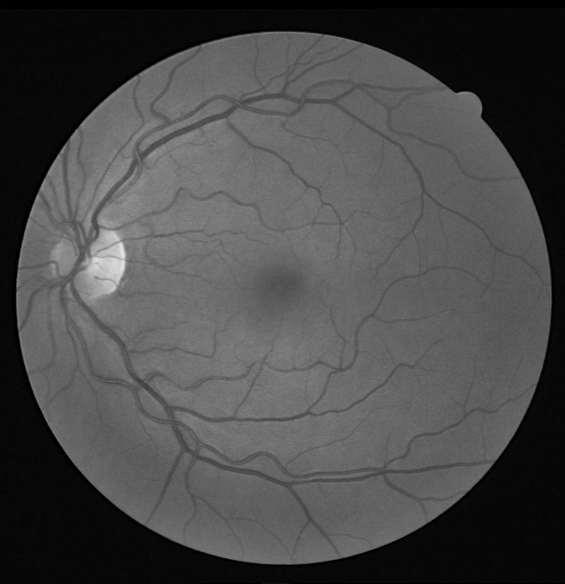

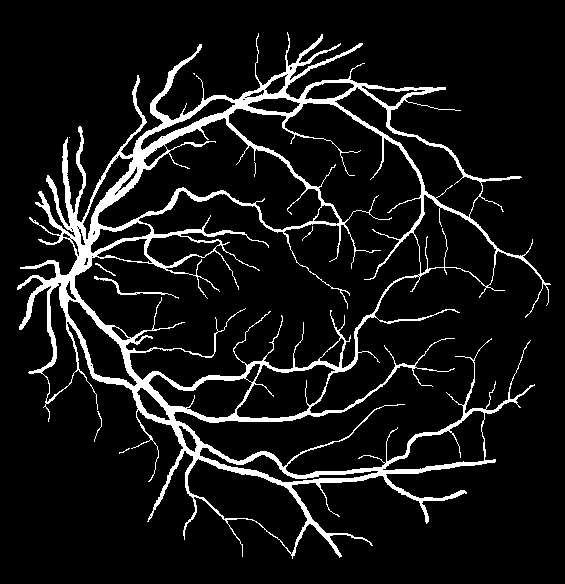

True


In [145]:
img_util.show(img, False)
img_util.show(label, True)
print(np.allclose(np.array(weight_pil), weight))

In [167]:
#img, label, weight = transf_to_imgaug(img_pil, label_pil, weight_pil)

In [49]:
tn = TransfNormalize(True, False, True)
tu = TransfUnormalize(True, False, True)
img, label, weight = transf_to_numpy(img_pil, label_pil, weight_pil)
img_n, label_n, weight_n = tu(*tn(img, label, weight))

In [50]:
print(img_n.max(), label_n.max(), weight_n.max())

255 1 1.0


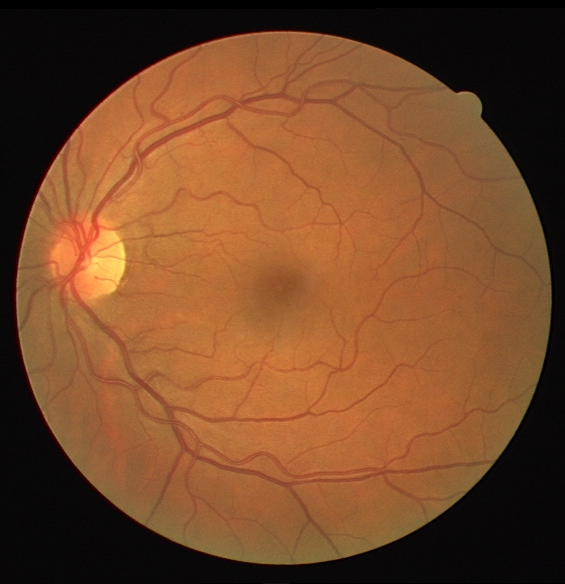

In [41]:
imgaug_to_pil(img_n)